# Red neural recurrente para regresión.

## Sección 2 - Proyecto (4) - Equipo #4 (T3)
- Alejandro Molina
- Sandro Portanova
- Carlos Fornari

La red impementada en este programa "aprende" (con una neurona) a contar los "unos" en una secuencia binaria, esto es, resuelve un problema lineal.

El proyecto se trata de modificar ese programa, para que resuelva un problema no lineal: predecir el valor futuro de una serie de datos, dados $n$ valores pasados de la misma serie.

## Librerias

In [236]:
import numpy as np # Librería para manejo de vectores y matrices
import math # Librería para funciones matemáticas
import matplotlib.pyplot as plt # Librería para graficar

from sklearn.model_selection import train_test_split

# Semilla aleatoria fija
np.random.seed(seed=1)

# Librerías utilizadas para el modelo
from keras.layers import Input, SimpleRNN, Dense
from keras.models import Model

## Generación de los datos.

#### Datos para la aproximación lineal.

In [237]:
nb_of_samples = 1000
sequence_len = 10

# Creamos las secuencias y las etiquetas

# Crea las secuencias
X = np.zeros((nb_of_samples, sequence_len))
for row_idx in range(nb_of_samples):
    X[row_idx,:] = np.around(np.random.rand(sequence_len)).astype(int)
# Crea las etiquetas
t = np.sum(X, axis=1)

In [238]:
# Dividimos los datos en entrenamiento y prueba
X_train, X_test, t_train, t_test = train_test_split(X, t, test_size=0.3)

#### Datos para la aproximación no lineal.

In [239]:
sin_wave = np.array([math.sin(x) for x in np.arange(200)])

x = []
y = []

seq_len = 50
num_records = len(sin_wave) - seq_len

for i in range(num_records - 50):
    x.append(sin_wave[i:i+seq_len])
    y.append(sin_wave[i+seq_len])
    
x = np.array(x)
x = np.expand_dims(x, axis=2)

y = np.array(y)
y = np.expand_dims(y, axis=1)

In [240]:
# Dividiendo el conjunto de datos no lineales en entrenamiento y prueba
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

## Forward pass.

In [241]:
def update_state(xk, sk, wx, wRec):
    """
    Calcula el estado hk a partir del estado anterior (sk) y la entrada 
    actual (xk), utilizando los pesos de entrada (wx) y los pesos recursivos (wRec). 
    recursivos (wRec)
    """
    return xk * wx + sk * wRec

def forward_states(X, wx, wRec):
    """
    Despliega la red y calcula todas las activaciones de estado, 
    dada la entrada X, los pesos de entrada (wx) y los pesos recursivos 
    (wRec). Devuelve las activaciones de estado en una matriz, la última 
    columna S[:,-1] contiene las activaciones finales.
    """
    # Inicializa la matriz que contiene todos los estados para todas 
    # secuencias de entrada. El estado inicial s0 es 0.
    S = np.zeros((X.shape[0], X.shape[1]+1))

    # Usa la relación de recurrencia definida por update_state para actualizar 
    # los estados a través del tiempo.
    for k in range(0, X.shape[1]):
        # S[k] = S[k-1] * wRec + X[k] * wx
        S[:,k+1] = update_state(X[:,k], S[:,k], wx, wRec)
    return S

def loss(y, t): 
    """MSE(Error mínimo cuadrado) entre los objetivos t y los resultados y."""
    return np.mean((t - y)**2)

## Backward pass... y otras cosas...

In [242]:
def output_gradient(y, t):
    """
    Gradiente de la función de pérdida MSE con respecto a la salida y.
    """
    return 2. * (y - t)

def backward_gradient(X, S, grad_out, wRec):
    """
    Propaga hacia atrás el gradiente calculado en la salida (grad_out) 
    a través de la red. Acumula los gradientes de los parámetros 
    wX y wRec por cada capa. Devuelve los gradientes 
    como una tupla y los gradientes a la salida de cada capa.
    """
    # Inicializa la matriz que almacena los gradientes de la pérdida con 
    # respecto a los estados.
    grad_over_time = np.zeros((X.shape[0], X.shape[1]+1))
    grad_over_time[:,-1] = grad_out

    # Pone en 0 las acumulaciones de gradiente
    wx_grad = 0
    wRec_grad = 0

    for k in range(X.shape[1], 0, -1):
        # Calcula los parámetros y acumula los resultados.
        wx_grad += np.sum(np.mean(grad_over_time[:,k] * X[:,k-1], axis=0))
        wRec_grad += np.sum(np.mean(grad_over_time[:,k] * S[:,k-1]), axis=0)
        
        # Calcula el gradiente en la salida de la capa anterior
        grad_over_time[:,k-1] = grad_over_time[:,k] * wRec
        
    return (wx_grad, wRec_grad), grad_over_time

#### Comprobación de gradiente

In [243]:
# Establece los parámetros de peso utilizados durante la comprobación del gradiente
params = [1.2, 1.2]  # [wx, wRec]

# Establece el pequeño cambio para calcular el gradiente numérico
eps = 1e-7

# Calcula los gradientes de retropropagación
S = forward_states(X_train, params[0], params[1])
grad_out = output_gradient(S[:,-1], t_train)
backprop_grads, grad_over_time = backward_gradient(X_train, S, grad_out, params[1])

# Calcula el gradiente numérico de cada parámetro de la capa
for p_idx, _ in enumerate(params):
    grad_backprop = backprop_grads[p_idx]
    # + eps
    params[p_idx] += eps
    plus_loss = loss(forward_states(X_train, params[0], params[1])[:,-1], t_train)
    # - eps
    params[p_idx] -= 2 * eps
    min_loss = loss(forward_states(X_train, params[0], params[1])[:,-1], t_train)
    # resetea el valor de param
    params[p_idx] += eps
    # calcula el gradiente numérico
    grad_num = (plus_loss - min_loss) / (2*eps)
    # Aumenta el error si numerical grade no es cercano a
    # el gradiente de retropropagación
    if not np.isclose(grad_num, grad_backprop):
        raise ValueError((
            f'Gradiente numérico de {grad_num:.6f} no es cercano a '
            f'el gradiente de retropropagación de {grad_backprop:.6f}!'))
print('No se encontraron errores en la comparación')


No se encontraron errores en la comparación


#### Actualizacion de los pesos con Rprop

In [244]:
# Define función de optimisación Rprop 
def update_rprop(X, t, W, W_prev_sign, W_delta, eta_p, eta_n):
    """
    Actualiza los valores de Rprop en una iteración.
    Args:
        X: datos de entrada.
        t: objetivos.
        W: parámetros de peso actuales.
        W_prev_signo: Signo anterior del gradiente W.
        W_delta: Valores de actualización de Rprop (Delta).
        eta_p, eta_n: Hiperparámetros de Rprop.
    Devuelve:
        (W_delta, W_sign): Actualización del peso y signo del último
                           gradiente.
    """
    # Realiza pasos hacia delante y hacia atrás para obtener los gradientes
    S = forward_states(X, W[0], W[1])

    # Calculamos el error de salida y el gradiente
    error = loss(S[:,-1], t)
    
    # Calcula el gradiente en la salida de la capa
    grad_out = output_gradient(S[:,-1], t)
    W_grads, _ = backward_gradient(X, S, grad_out, W[1])
    W_sign = np.sign(W_grads) # Signo del nuevo gradiente
    # Actualizar el Delta (valor de actualización) para cada 
    # parámetro por separado
    for i, _ in enumerate(W):
        if W_sign[i] == W_prev_sign[i]:
            W_delta[i] *= eta_p
        else:
            W_delta[i] *= eta_n
    return W_delta, W_sign, error


In [245]:
# Perform Rprop optimisation
def perform_rprop(X, t, init_w, init_w_delta, eta_p, eta_n, no_epochs):
    """
    Realiza la optimización de Rprop durante no_epochs (iteraciones).
    Devuelve una lista con los valores de peso de cada iteración.
    """
    # Inicializa los pesos y los valores de actualización
    W = init_w[:]
    W_delta = init_w_delta[:]
    W_sign = [0, 0]

    # Guarda los pesos en una lista para graficar
    ls_of_ws = [(W[0], W[1])]

    # Lista de los errores
    errors = []

    # Itera a través de las épocas
    for i in range(no_epochs):
        # Actualiza los valores y signos del último gradiente
        W_delta, W_sign, error = update_rprop(X, t, W, W_sign, W_delta, eta_p, eta_n)

        # Guardamos el error
        errors.append(error)

        # Actualiza cada peso separadamente
        for i, _ in enumerate(W):
            W[i] -= W_sign[i] * W_delta[i]
        ls_of_ws.append((W[0], W[1]))  # Guarda los pesos para graficar
        
    return ls_of_ws, W, errors

#### Graficamos los resultados de los pesos y el error

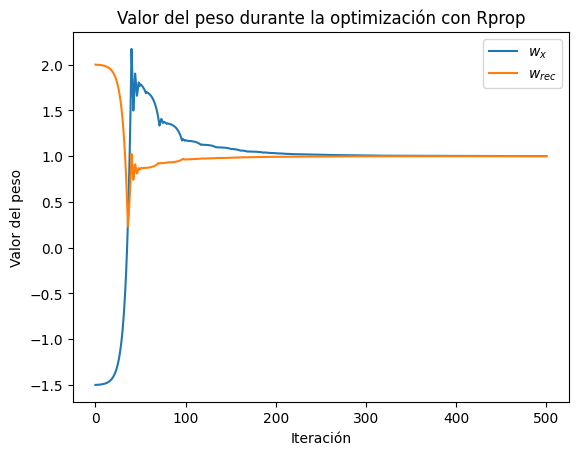

In [246]:
ls_of_ws, W_result, errores = perform_rprop(X_train, t_train, init_w=[-1.5, 2],init_w_delta=[0.001, 0.001],eta_p=1.2, eta_n=0.5, no_epochs=500)

# Grafica de los pesos
plt.plot(ls_of_ws)
plt.legend([r'$w_x$', r'$w_{rec}$'])
plt.xlabel('Iteración')
plt.ylabel('Valor del peso')
plt.title('Valor del peso durante la optimización con Rprop')
plt.show()

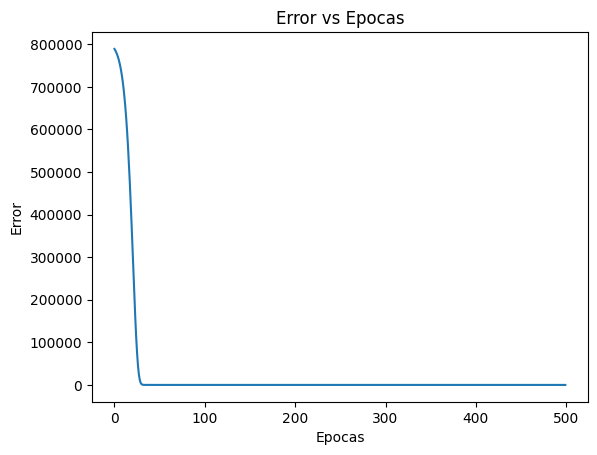

El error final es:  1.7837869236139286e-07


In [247]:
# Grafica del error respecto epocas
plt.plot(errores)
plt.xlabel('Epocas')
plt.ylabel('Error')
plt.title('Error vs Epocas')
plt.show()

print('El error final es: ', errores[-1])

#### Desempeño.

In [248]:
# Probamos el desempeño con el error de entrenamiento
S_test = forward_states(X_test, W_result[0], W_result[1])
error_test = loss(S_test[:,-1], t_test)
print(f'Error en el conjunto de prueba después de la optimización de Rprop: {error_test:.3f}')

# Mostramos el total de (1) en el conjunto de prueba
print('Total de (1) en el conjunto de prueba: ', t_test.sum())

# Mostramos el total de (1) en los resultados
print('Total de (1) en los resultados: ', np.around(S_test[:,-1]).sum())

Error en el conjunto de prueba después de la optimización de Rprop: 0.000
Total de (1) en el conjunto de prueba:  1522.0
Total de (1) en los resultados:  1522.0


## Creando un modelo de red neuronal recurrente. Usando tensorflow.

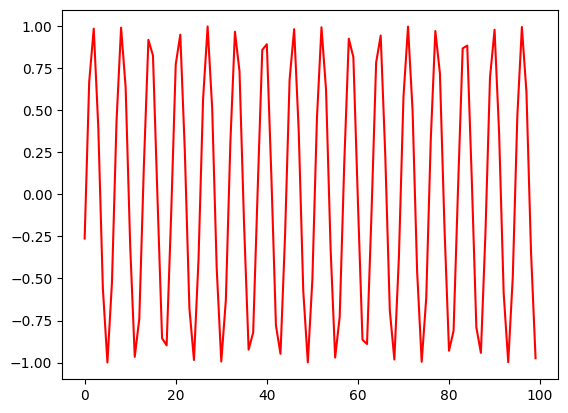

In [249]:
# Graficamos los datos primero
plt.plot(y[:, 0], 'r')
plt.show()

#### Definimos el modelo usando TensorFlow

In [250]:
class Rnn_model:
    def __init__(self, input_neurons, hidden_neurons, output_neurons, sequence_length):
        self.input_neurons = input_neurons
        self.output_neurons = output_neurons
        self.hidden_neurons = hidden_neurons

        input_layer = Input(batch_shape=(None, sequence_length, input_neurons))

        hidden_layer = SimpleRNN(
            hidden_neurons,
            return_sequences=False,
            stateful=False,
            name="Hidden",
        )(input_layer)

        output_layer = Dense(output_neurons, name="Output")(hidden_layer)
        model = Model(inputs=[input_layer], outputs=[output_layer])

        model.compile(loss="mean_squared_error", optimizer="rmsprop")

        self.model = model
        self.input_layer = input_layer
        self.hidden_layer = hidden_layer
        self.output_layer = output_layer

        model.summary()

    def train(self, x_train, y_train, epochs=1000):
        return self.model.fit(
            x_train,
            y_train,
            batch_size=600,
            epochs=epochs,
            verbose=False,
            validation_split=0.05,
        )

    def predict(self, x):
        return self.model.predict(x)


model = Rnn_model(1, 4, 1, x_train.shape[1])

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 50, 1)]           0         
                                                                 
 Hidden (SimpleRNN)          (None, 4)                 24        
                                                                 
 Output (Dense)              (None, 1)                 5         
                                                                 
Total params: 29 (116.00 Byte)
Trainable params: 29 (116.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#### Entrenamos el modelo

In [251]:
hist = model.train(x_train, y_train, 1000)

### Graficamos diversos resultados

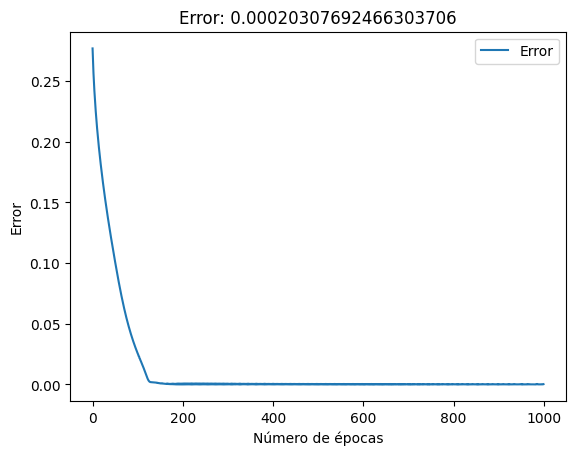

In [252]:
# Graficamos el error de entrenamiento y validación
plt.plot(hist.history['val_loss'],label='Error')
plt.ylabel("Error")
plt.xlabel("Número de épocas")
plt.title("Error: {}".format(hist.history["val_loss"][-1]))
plt.legend()
plt.show()

#### Probamos el modelo con datos de prueba y graficamos

1/1 [==============================] - 0s 60ms/step


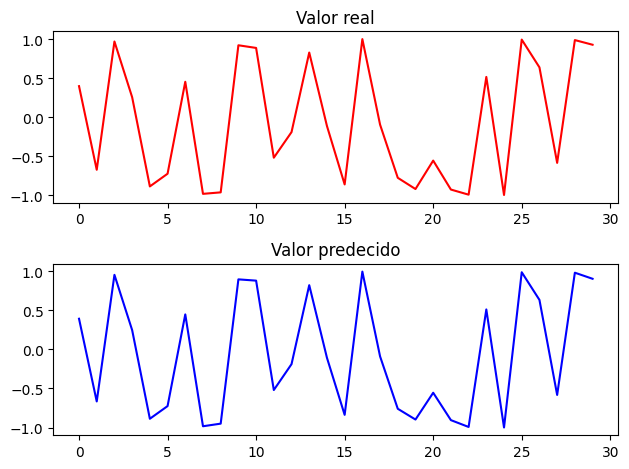

In [253]:
# Predecimos los valores
y_pred = model.predict(x_test)

# Graficamos usando subplot para mostrar los resultados
plt.subplot(2, 1, 1)
plt.plot(y_test, 'r')
plt.title('Valor real')
plt.subplot(2, 1, 2)
plt.plot(y_pred, 'b')
plt.title('Valor predecido')
plt.tight_layout()
plt.show()
